<a href="https://colab.research.google.com/github/vjhawar12/Vision-Transformer-paper-implementation/blob/main/ViT_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install lightning-bolts

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.8/300.8 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
!pip install timm

In [4]:
import torch
import torchvision
import torch.nn as nn
from math import sqrt, cos, pi
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.transforms.v2 import CutMix, MixUp, RandomChoice
from timm.loss import SoftTargetCrossEntropy
from timm.models.layers import DropPath
from torch.optim.lr_scheduler import LambdaLR, CosineAnnealingLR

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [ ]:
# image pre-processing helper class

class PatchEmbedding(nn.Module):

    def __init__(self, batches=32, in_channels=3, patch_size=16, size=128, embed_dim=768):
        super().__init__()

        assert size % patch_size == 0, "Image size must be divisible by patch size"

        self.batches = batches
        self.in_channels = in_channels # rgb ==> 3 channels
        self.patch_size = patch_size # size of each patch (like a token)
        self.embed_dim = embed_dim # the higher-dimensional space to project the patches to
        self.size = size # size of input image
        self.N = (self.size // self.patch_size) ** 2 # number of patches

        self.proj = nn.Conv2d(in_channels=self.in_channels, # B, C, H, W --> B, D, H_p, W_p
                              out_channels=self.embed_dim, # 3D space --> 768D space to extract more information
                              kernel_size=self.patch_size, # so that the patches don't overlap
                              stride=self.patch_size) # divides input image into patches

        self.cls_token = nn.Parameter(torch.randn(1, 1, self.embed_dim)) # token which captures the 'meaning' of the image in a vector
        self.pos_embeddings = nn.Parameter(torch.randn(1, self.N + 1, self.embed_dim)) # learnable positional embeddings

    def forward(self, x):
        x = self.proj(x) # applying conv2d projection
        x = torch.flatten(x, 2) # B, D, N
        x = x.transpose(1, 2) # B, N, D
        B = x.shape[0]
        cls_token = self.cls_token.expand(B, -1, -1) # expanding the cls token along the batch dimension so it can be added later
        x = torch.cat((cls_token, x), dim=1) # adding the cls token to the input tensor
        x = x + self.pos_embeddings # adding the positional embeddings to the input tensor

        return x

In [ ]:
# A head has unique Q, K, V matrices and computes attention

class ManualMultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim=768, heads=12, dropout=0.15):
        super().__init__()

        assert embed_dim % heads == 0, "Embedding dimension must be divisible by heads"

        self.embed_dim = embed_dim
        self.heads = heads
        self.head_dim = embed_dim // heads

        # fully connected NN layers with # of input neurons = embed_dim = # output neurons
        self.Q_proj = nn.Linear(embed_dim, embed_dim)
        self.V_proj = nn.Linear(embed_dim, embed_dim)
        self.K_proj = nn.Linear(embed_dim, embed_dim)

        self.dropout = nn.Dropout(dropout)

        self.output = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, N, D = x.shape

        # Q: what it's looking for
        # K: the kind of features it has
        # V: the actual representation

        # sending the input tensor through proj NN layers
        Q = self.Q_proj(x) # batches, patches, embed_dim
        Q = Q.view(B, N, self.heads, self.head_dim).permute(0, 2, 1, 3) # single head --> multihead

        V = self.V_proj(x) # batches, patches, embed_dim
        V = V.view(B, N, self.heads, self.head_dim).permute(0, 2, 1, 3) # single head --> multihead

        K = self.K_proj(x) # batches, patches, embed_dim
        K = K.view(B, N, self.heads, self.head_dim).permute(0, 2, 1, 3) # single head --> multihead

        # computing attention
        x = self.compute_attention(Q, K, V).permute(0, 2, 1, 3).contiguous() # B, heads, N, head_dim --> B, N, heads, head_dim
        x = self.dropout(x)
        x = x.view(B, N, D)
        x = self.output(x)

        return x

    def compute_attention(self, Q, K, V):
        K_T = torch.transpose(K, -2, -1) # transpose so that multiplication is defined
        scaling = sqrt(self.head_dim)
        val = torch.matmul(Q, K_T) / scaling

        return torch.matmul(torch.softmax(val, dim=-1), V)


In [ ]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim=768, heads=12, dropout=0.15):
        super().__init__()

        self.mhsa = ManualMultiHeadSelfAttention(embed_dim, heads)
        self.ln1 = nn.LayerNorm(embed_dim)
        self.drop_path_1 = DropPath(0.05)
        self.drop_path_2 = DropPath(0.05)

        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim, embed_dim),
            nn.GELU(),
            nn.Dropout(dropout),
        )

        self.ln2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = self.ln1(x) # normalizing activation functions to prevent saturation. Pre-norm is expected to lead to faster convergence.
        attn_out = self.mhsa(x) # computing residual
        x = x + self.drop_path_1(attn_out) # skip connection
        x = self.ln2(x) # normalizing activation functions to prevent saturation
        ffn_out = self.ffn(x) # computing residual
        x = x + self.drop_path_2(ffn_out) # skip connection

        return x


In [ ]:
class VisionTransformer(nn.Module):
    def __init__(self,  batches=32, in_channels=3, patch_size=16, size=128, embed_dim=768, heads=12, depth=8, num_classes=10, dropout=0.15):
        super().__init__()

        self.patch_embedding = PatchEmbedding(batches, in_channels, patch_size, size, embed_dim)

        # each transformer applies attention through various heads -- each with unique Q, K, and V matrices
        self.transformer_stack = nn.ModuleList(TransformerEncoder(embed_dim, heads) for _ in range(depth))

        self.mlp_head = nn.Sequential( # maps cls token to logits
            nn.Dropout(dropout),
            nn.Linear(in_features=embed_dim, out_features=num_classes),
        )

    def forward(self, x):
        x = self.patch_embedding(x)

        for t in self.transformer_stack:
            x = t(x)

        cls = x[:, 0]
        x = self.mlp_head(cls)

        return x

In [ ]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(64),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomCrop(64, padding=4),
    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768)) # normalizing mean helps optims like Adam, scaling ensures uniformity across the inputs
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(64),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))
])


training_data = datasets.CIFAR10(root="data", train=True, download=True, transform=train_transform)
test_data = datasets.CIFAR10(root="data", train=False, download=False,  transform=test_transform)

100%|██████████| 170M/170M [00:13<00:00, 13.0MB/s]


In [ ]:
batchsize = 512
channels = 3
patchsize = 4
imsize = 64
embeddim = 252
numheads = 12
encoders = 8
numclasses = 10
epochs = 100
dropout = 0.05
mixup_start = 10
cutmix_or_mixup_start = 20
max_mixup = 0.5
max_cutmix_or_mixup = 0.5
alpha = 0.25

In [ ]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cuda.enable_flash_sdp(True)
torch.backends.cuda.enable_mem_efficient_sdp(True)
torch.backends.cuda.enable_math_sdp(True)

In [ ]:
train_dataloader = DataLoader(dataset=training_data, batch_size=batchsize, shuffle=True, pin_memory=True, num_workers=8)
test_dataloader = DataLoader(dataset=test_data, batch_size=batchsize, shuffle=False)

cutmix = CutMix(num_classes=numclasses)
mixup = MixUp(num_classes=numclasses, alpha=alpha)

vit = VisionTransformer(
    batches=batchsize, in_channels=channels,
    patch_size=patchsize, embed_dim=embeddim,
    heads=numheads, depth=encoders, size=imsize,
    num_classes=numclasses,
)

vit = torch.compile(vit)

loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
sft_loss_fn = SoftTargetCrossEntropy()
optim = torch.optim.AdamW(params=vit.parameters(), lr=1e-3, weight_decay=0.05)

def sched_func(epoch):
  if epoch < 10:
    return 1 - ((10 - epoch) / 10)

  if 10 <= epoch <= 40:
    return 1

  progress = (epoch - 40) / 60
  return 0.5 * (1 + cos(pi * progress))

scheduler = LambdaLR(optim, lr_lambda=sched_func)

scaler = torch.amp.GradScaler()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit.to(device)

OptimizedModule(
  (_orig_mod): VisionTransformer(
    (patch_embedding): PatchEmbedding(
      (proj): Conv2d(3, 252, kernel_size=(4, 4), stride=(4, 4))
    )
    (transformer_stack): ModuleList(
      (0-7): 8 x TransformerEncoder(
        (mhsa): ManualMultiHeadSelfAttention(
          (Q_proj): Linear(in_features=252, out_features=252, bias=True)
          (V_proj): Linear(in_features=252, out_features=252, bias=True)
          (K_proj): Linear(in_features=252, out_features=252, bias=True)
          (dropout): Dropout(p=0.15, inplace=False)
          (output): Linear(in_features=252, out_features=252, bias=True)
        )
        (ln1): LayerNorm((252,), eps=1e-05, elementwise_affine=True)
        (drop_path_1): DropPath(drop_prob=0.050)
        (drop_path_2): DropPath(drop_prob=0.050)
        (ffn): Sequential(
          (0): Linear(in_features=252, out_features=252, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.15, inplace=False)
          (3): Lin

In [ ]:
for i in range(epochs):
    torch.cuda.empty_cache()
    correct, total = 0, 0
    running_loss = 0

    vit.train(True)

    loop = tqdm(train_dataloader, desc=f"Epoch {i+1}/{epochs}", leave=True, disable=False)

    for j, (input, labels) in enumerate(loop, 1):
        input, labels = input.to(device), labels.to(device)
        optim.zero_grad()

        if i >= cutmix_or_mixup_start and torch.rand(1) < min(max_cutmix_or_mixup, i/100):
          cutmix_or_mixup = RandomChoice([cutmix, mixup], p=[0.3, 0.7])
          input, labels = cutmix_or_mixup(input, labels)

        elif i >= mixup_start and torch.rand(1) < min(max_mixup, i/100):
          input, labels = mixup(input, labels)

        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
          output = vit(input)

          if labels.ndim == 2:
            loss = sft_loss_fn(output, labels)
            running_loss += loss.mean().item()
          else:
            loss = loss_fn(output, labels)
            running_loss += loss.item()

        scaler.scale(loss).backward()
        scaler.step(optim)
        scaler.update()

        avg_loss = running_loss / j
        loop.set_postfix(loss=avg_loss)

        pred = torch.argmax(output, dim=1)

        if labels.ndim == 2:
          labels = labels.argmax(dim=1)

        total += labels.size(0)
        correct += (pred == labels).sum().item()


    vit.eval()
    val_total, val_correct = 0, 0

    with torch.no_grad():
        for image, label in test_dataloader:
            image, label = image.to(device), label.to(device)

            with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
              output = vit(image)

            pred = torch.argmax(output, dim=1)
            val_total += label.size(0)
            val_correct += (pred == label).sum().item()

        val_accuracy = val_correct / val_total
        accuracy = correct / total


    scheduler.step()

    current_lr = optim.param_groups[0]['lr']
    print(f"Epoch {i + 1}: LR={current_lr:.6f} \t Train Acc: {accuracy:.4f} \t Val Acc: {val_accuracy:.4f}")

Epoch 1/100: 100%|██████████| 98/98 [02:38<00:00,  1.61s/it, loss=2.53]


Epoch 1: LR=0.000100 	 Train Acc: 0.1034 	 Val Acc: 0.1102


Epoch 2/100: 100%|██████████| 98/98 [00:20<00:00,  4.89it/s, loss=2.16]


Epoch 2: LR=0.000200 	 Train Acc: 0.2071 	 Val Acc: 0.2693


Epoch 3/100: 100%|██████████| 98/98 [00:20<00:00,  4.84it/s, loss=2.02]


Epoch 3: LR=0.000300 	 Train Acc: 0.2839 	 Val Acc: 0.3741


Epoch 4/100: 100%|██████████| 98/98 [00:20<00:00,  4.84it/s, loss=1.85]


Epoch 4: LR=0.000400 	 Train Acc: 0.3756 	 Val Acc: 0.4646


Epoch 5/100: 100%|██████████| 98/98 [00:20<00:00,  4.86it/s, loss=1.72]


Epoch 5: LR=0.000500 	 Train Acc: 0.4406 	 Val Acc: 0.5182


Epoch 6/100: 100%|██████████| 98/98 [00:20<00:00,  4.87it/s, loss=1.63]


Epoch 6: LR=0.000600 	 Train Acc: 0.4819 	 Val Acc: 0.5509


Epoch 7/100: 100%|██████████| 98/98 [00:20<00:00,  4.82it/s, loss=1.57]


Epoch 7: LR=0.000700 	 Train Acc: 0.5123 	 Val Acc: 0.5581


Epoch 8/100: 100%|██████████| 98/98 [00:20<00:00,  4.86it/s, loss=1.52]


Epoch 8: LR=0.000800 	 Train Acc: 0.5376 	 Val Acc: 0.5822


Epoch 9/100: 100%|██████████| 98/98 [00:20<00:00,  4.82it/s, loss=1.47]


Epoch 9: LR=0.000900 	 Train Acc: 0.5607 	 Val Acc: 0.5799


Epoch 10/100: 100%|██████████| 98/98 [00:20<00:00,  4.86it/s, loss=1.45]


Epoch 10: LR=0.001000 	 Train Acc: 0.5697 	 Val Acc: 0.6086


Epoch 11/100: 100%|██████████| 98/98 [00:20<00:00,  4.83it/s, loss=1.41]


Epoch 11: LR=0.001000 	 Train Acc: 0.5785 	 Val Acc: 0.6154


Epoch 12/100: 100%|██████████| 98/98 [00:20<00:00,  4.80it/s, loss=1.38]


Epoch 12: LR=0.001000 	 Train Acc: 0.5982 	 Val Acc: 0.6405


Epoch 13/100: 100%|██████████| 98/98 [00:20<00:00,  4.82it/s, loss=1.34]


Epoch 13: LR=0.001000 	 Train Acc: 0.6170 	 Val Acc: 0.6489


Epoch 14/100: 100%|██████████| 98/98 [00:20<00:00,  4.81it/s, loss=1.32]


Epoch 14: LR=0.001000 	 Train Acc: 0.6265 	 Val Acc: 0.6506


Epoch 15/100: 100%|██████████| 98/98 [00:20<00:00,  4.82it/s, loss=1.29]


Epoch 15: LR=0.001000 	 Train Acc: 0.6424 	 Val Acc: 0.6707


Epoch 16/100: 100%|██████████| 98/98 [00:20<00:00,  4.81it/s, loss=1.28]


Epoch 16: LR=0.001000 	 Train Acc: 0.6443 	 Val Acc: 0.6899


Epoch 17/100: 100%|██████████| 98/98 [00:20<00:00,  4.89it/s, loss=1.25]


Epoch 17: LR=0.001000 	 Train Acc: 0.6591 	 Val Acc: 0.6950


Epoch 18/100: 100%|██████████| 98/98 [00:20<00:00,  4.83it/s, loss=1.26]


Epoch 18: LR=0.001000 	 Train Acc: 0.6581 	 Val Acc: 0.6936


Epoch 19/100: 100%|██████████| 98/98 [00:20<00:00,  4.85it/s, loss=1.27]


Epoch 19: LR=0.001000 	 Train Acc: 0.6572 	 Val Acc: 0.7030


Epoch 20/100: 100%|██████████| 98/98 [00:20<00:00,  4.86it/s, loss=1.2]


Epoch 20: LR=0.001000 	 Train Acc: 0.6828 	 Val Acc: 0.7026


Epoch 21/100: 100%|██████████| 98/98 [00:20<00:00,  4.87it/s, loss=1.25]


Epoch 21: LR=0.001000 	 Train Acc: 0.6594 	 Val Acc: 0.7066


Epoch 22/100: 100%|██████████| 98/98 [00:20<00:00,  4.80it/s, loss=1.28]


Epoch 22: LR=0.001000 	 Train Acc: 0.6526 	 Val Acc: 0.6786


Epoch 23/100: 100%|██████████| 98/98 [00:20<00:00,  4.83it/s, loss=1.2]


Epoch 23: LR=0.001000 	 Train Acc: 0.6847 	 Val Acc: 0.7114


Epoch 24/100: 100%|██████████| 98/98 [00:20<00:00,  4.82it/s, loss=1.26]


Epoch 24: LR=0.001000 	 Train Acc: 0.6557 	 Val Acc: 0.7126


Epoch 25/100: 100%|██████████| 98/98 [00:20<00:00,  4.80it/s, loss=1.24]


Epoch 25: LR=0.001000 	 Train Acc: 0.6701 	 Val Acc: 0.7129


Epoch 26/100: 100%|██████████| 98/98 [00:20<00:00,  4.81it/s, loss=1.21]


Epoch 26: LR=0.001000 	 Train Acc: 0.6816 	 Val Acc: 0.7012


Epoch 27/100: 100%|██████████| 98/98 [00:20<00:00,  4.79it/s, loss=1.13]


Epoch 27: LR=0.001000 	 Train Acc: 0.7027 	 Val Acc: 0.7298


Epoch 28/100: 100%|██████████| 98/98 [00:20<00:00,  4.82it/s, loss=1.2]


Epoch 28: LR=0.001000 	 Train Acc: 0.6885 	 Val Acc: 0.7400


Epoch 29/100: 100%|██████████| 98/98 [00:20<00:00,  4.85it/s, loss=1.23]


Epoch 29: LR=0.001000 	 Train Acc: 0.6821 	 Val Acc: 0.7377


Epoch 30/100: 100%|██████████| 98/98 [00:20<00:00,  4.77it/s, loss=1.12]


Epoch 30: LR=0.001000 	 Train Acc: 0.7080 	 Val Acc: 0.7485


Epoch 31/100: 100%|██████████| 98/98 [00:20<00:00,  4.84it/s, loss=1.12]


Epoch 31: LR=0.001000 	 Train Acc: 0.7057 	 Val Acc: 0.7508


Epoch 32/100: 100%|██████████| 98/98 [00:20<00:00,  4.88it/s, loss=1.14]


Epoch 32: LR=0.001000 	 Train Acc: 0.7050 	 Val Acc: 0.7471


Epoch 33/100: 100%|██████████| 98/98 [00:20<00:00,  4.87it/s, loss=1.21]


Epoch 33: LR=0.001000 	 Train Acc: 0.6907 	 Val Acc: 0.7552


Epoch 34/100: 100%|██████████| 98/98 [00:20<00:00,  4.81it/s, loss=1.16]


Epoch 34: LR=0.001000 	 Train Acc: 0.7069 	 Val Acc: 0.7624


Epoch 35/100: 100%|██████████| 98/98 [00:20<00:00,  4.87it/s, loss=1.16]


Epoch 35: LR=0.001000 	 Train Acc: 0.7034 	 Val Acc: 0.7692


Epoch 36/100: 100%|██████████| 98/98 [00:20<00:00,  4.86it/s, loss=1.15]


Epoch 36: LR=0.001000 	 Train Acc: 0.7136 	 Val Acc: 0.7693


Epoch 37/100: 100%|██████████| 98/98 [00:20<00:00,  4.83it/s, loss=1.1]


Epoch 37: LR=0.001000 	 Train Acc: 0.7210 	 Val Acc: 0.7632


Epoch 38/100: 100%|██████████| 98/98 [00:20<00:00,  4.80it/s, loss=1.16]


Epoch 38: LR=0.001000 	 Train Acc: 0.7056 	 Val Acc: 0.7784


Epoch 39/100: 100%|██████████| 98/98 [00:20<00:00,  4.81it/s, loss=1.09]


Epoch 39: LR=0.001000 	 Train Acc: 0.7321 	 Val Acc: 0.7687


Epoch 40/100: 100%|██████████| 98/98 [00:20<00:00,  4.81it/s, loss=1.1]


Epoch 40: LR=0.001000 	 Train Acc: 0.7163 	 Val Acc: 0.7778


Epoch 41/100: 100%|██████████| 98/98 [00:20<00:00,  4.82it/s, loss=1.1]


Epoch 41: LR=0.000999 	 Train Acc: 0.7281 	 Val Acc: 0.7585


Epoch 42/100: 100%|██████████| 98/98 [00:20<00:00,  4.80it/s, loss=1.12]


Epoch 42: LR=0.000997 	 Train Acc: 0.7090 	 Val Acc: 0.7735


Epoch 43/100: 100%|██████████| 98/98 [00:20<00:00,  4.81it/s, loss=1.03]


Epoch 43: LR=0.000994 	 Train Acc: 0.7417 	 Val Acc: 0.7815


Epoch 44/100: 100%|██████████| 98/98 [00:20<00:00,  4.85it/s, loss=1.11]


Epoch 44: LR=0.000989 	 Train Acc: 0.7267 	 Val Acc: 0.7721


Epoch 45/100: 100%|██████████| 98/98 [00:20<00:00,  4.80it/s, loss=1.13]


Epoch 45: LR=0.000983 	 Train Acc: 0.7265 	 Val Acc: 0.7647


Epoch 46/100: 100%|██████████| 98/98 [00:20<00:00,  4.88it/s, loss=1.12]


Epoch 46: LR=0.000976 	 Train Acc: 0.7258 	 Val Acc: 0.7662


Epoch 47/100: 100%|██████████| 98/98 [00:20<00:00,  4.80it/s, loss=1.08]


Epoch 47: LR=0.000967 	 Train Acc: 0.7348 	 Val Acc: 0.7929


Epoch 48/100: 100%|██████████| 98/98 [00:20<00:00,  4.81it/s, loss=1.01]


Epoch 48: LR=0.000957 	 Train Acc: 0.7573 	 Val Acc: 0.7873


Epoch 49/100: 100%|██████████| 98/98 [00:20<00:00,  4.89it/s, loss=1.15]


Epoch 49: LR=0.000946 	 Train Acc: 0.7130 	 Val Acc: 0.7813


Epoch 50/100: 100%|██████████| 98/98 [00:20<00:00,  4.87it/s, loss=1.04]


Epoch 50: LR=0.000933 	 Train Acc: 0.7500 	 Val Acc: 0.7863


Epoch 51/100: 100%|██████████| 98/98 [00:20<00:00,  4.89it/s, loss=1.09]


Epoch 51: LR=0.000919 	 Train Acc: 0.7212 	 Val Acc: 0.7884


Epoch 52/100: 100%|██████████| 98/98 [00:20<00:00,  4.87it/s, loss=1.07]


Epoch 52: LR=0.000905 	 Train Acc: 0.7436 	 Val Acc: 0.7980


Epoch 53/100: 100%|██████████| 98/98 [00:20<00:00,  4.89it/s, loss=0.977]


Epoch 53: LR=0.000889 	 Train Acc: 0.7655 	 Val Acc: 0.7971


Epoch 54/100: 100%|██████████| 98/98 [00:20<00:00,  4.85it/s, loss=1.02]


Epoch 54: LR=0.000872 	 Train Acc: 0.7624 	 Val Acc: 0.7917


Epoch 55/100: 100%|██████████| 98/98 [00:20<00:00,  4.85it/s, loss=1.08]


Epoch 55: LR=0.000854 	 Train Acc: 0.7387 	 Val Acc: 0.7991


Epoch 56/100: 100%|██████████| 98/98 [00:20<00:00,  4.79it/s, loss=1.07]


Epoch 56: LR=0.000835 	 Train Acc: 0.7381 	 Val Acc: 0.8070


Epoch 57/100: 100%|██████████| 98/98 [00:20<00:00,  4.86it/s, loss=1.04]


Epoch 57: LR=0.000815 	 Train Acc: 0.7559 	 Val Acc: 0.8012


Epoch 58/100: 100%|██████████| 98/98 [00:20<00:00,  4.85it/s, loss=1.01]


Epoch 58: LR=0.000794 	 Train Acc: 0.7738 	 Val Acc: 0.8130


Epoch 59/100: 100%|██████████| 98/98 [00:20<00:00,  4.82it/s, loss=0.993]


Epoch 59: LR=0.000772 	 Train Acc: 0.7711 	 Val Acc: 0.8100


Epoch 60/100: 100%|██████████| 98/98 [00:20<00:00,  4.82it/s, loss=1.01]


Epoch 60: LR=0.000750 	 Train Acc: 0.7594 	 Val Acc: 0.8193


Epoch 61/100: 100%|██████████| 98/98 [00:20<00:00,  4.85it/s, loss=1.04]


Epoch 61: LR=0.000727 	 Train Acc: 0.7651 	 Val Acc: 0.8223


Epoch 62/100: 100%|██████████| 98/98 [00:20<00:00,  4.86it/s, loss=1]


Epoch 62: LR=0.000703 	 Train Acc: 0.7686 	 Val Acc: 0.8124


Epoch 63/100: 100%|██████████| 98/98 [00:20<00:00,  4.85it/s, loss=0.95]


Epoch 63: LR=0.000679 	 Train Acc: 0.7901 	 Val Acc: 0.8258


Epoch 64/100: 100%|██████████| 98/98 [00:20<00:00,  4.81it/s, loss=0.966]


Epoch 64: LR=0.000655 	 Train Acc: 0.7853 	 Val Acc: 0.8146


Epoch 65/100: 100%|██████████| 98/98 [00:20<00:00,  4.87it/s, loss=0.927]


Epoch 65: LR=0.000629 	 Train Acc: 0.8024 	 Val Acc: 0.8288


Epoch 66/100: 100%|██████████| 98/98 [00:20<00:00,  4.80it/s, loss=0.989]


Epoch 66: LR=0.000604 	 Train Acc: 0.7813 	 Val Acc: 0.8181


Epoch 67/100: 100%|██████████| 98/98 [00:20<00:00,  4.83it/s, loss=0.998]


Epoch 67: LR=0.000578 	 Train Acc: 0.7858 	 Val Acc: 0.8265


Epoch 68/100: 100%|██████████| 98/98 [00:20<00:00,  4.80it/s, loss=0.979]


Epoch 68: LR=0.000552 	 Train Acc: 0.7864 	 Val Acc: 0.8275


Epoch 69/100: 100%|██████████| 98/98 [00:20<00:00,  4.85it/s, loss=0.962]


Epoch 69: LR=0.000526 	 Train Acc: 0.8004 	 Val Acc: 0.8255


Epoch 70/100: 100%|██████████| 98/98 [00:20<00:00,  4.80it/s, loss=0.892]


Epoch 70: LR=0.000500 	 Train Acc: 0.8184 	 Val Acc: 0.8314


Epoch 71/100: 100%|██████████| 98/98 [00:20<00:00,  4.81it/s, loss=0.93]


Epoch 71: LR=0.000474 	 Train Acc: 0.8122 	 Val Acc: 0.8302


Epoch 72/100: 100%|██████████| 98/98 [00:20<00:00,  4.85it/s, loss=0.861]


Epoch 72: LR=0.000448 	 Train Acc: 0.8241 	 Val Acc: 0.8341


Epoch 73/100: 100%|██████████| 98/98 [00:20<00:00,  4.81it/s, loss=1.04]


Epoch 73: LR=0.000422 	 Train Acc: 0.7788 	 Val Acc: 0.8357


Epoch 74/100: 100%|██████████| 98/98 [00:20<00:00,  4.78it/s, loss=0.824]


Epoch 74: LR=0.000396 	 Train Acc: 0.8399 	 Val Acc: 0.8381


Epoch 75/100: 100%|██████████| 98/98 [00:20<00:00,  4.79it/s, loss=0.879]


Epoch 75: LR=0.000371 	 Train Acc: 0.8254 	 Val Acc: 0.8367


Epoch 76/100: 100%|██████████| 98/98 [00:20<00:00,  4.87it/s, loss=0.983]


Epoch 76: LR=0.000345 	 Train Acc: 0.7898 	 Val Acc: 0.8428


Epoch 77/100: 100%|██████████| 98/98 [00:20<00:00,  4.86it/s, loss=0.85]


Epoch 77: LR=0.000321 	 Train Acc: 0.8362 	 Val Acc: 0.8405


Epoch 78/100: 100%|██████████| 98/98 [00:20<00:00,  4.87it/s, loss=0.822]


Epoch 78: LR=0.000297 	 Train Acc: 0.8249 	 Val Acc: 0.8395


Epoch 79/100: 100%|██████████| 98/98 [00:20<00:00,  4.79it/s, loss=0.83]


Epoch 79: LR=0.000273 	 Train Acc: 0.8479 	 Val Acc: 0.8432


Epoch 80/100: 100%|██████████| 98/98 [00:20<00:00,  4.87it/s, loss=0.823]


Epoch 80: LR=0.000250 	 Train Acc: 0.8453 	 Val Acc: 0.8447


Epoch 81/100: 100%|██████████| 98/98 [00:20<00:00,  4.85it/s, loss=0.778]


Epoch 81: LR=0.000228 	 Train Acc: 0.8558 	 Val Acc: 0.8443


Epoch 82/100: 100%|██████████| 98/98 [00:20<00:00,  4.80it/s, loss=0.894]


Epoch 82: LR=0.000206 	 Train Acc: 0.8232 	 Val Acc: 0.8469


Epoch 83/100: 100%|██████████| 98/98 [00:20<00:00,  4.84it/s, loss=0.713]


Epoch 83: LR=0.000185 	 Train Acc: 0.8710 	 Val Acc: 0.8514


Epoch 84/100: 100%|██████████| 98/98 [00:20<00:00,  4.79it/s, loss=0.928]


Epoch 84: LR=0.000165 	 Train Acc: 0.8128 	 Val Acc: 0.8514


Epoch 85/100: 100%|██████████| 98/98 [00:20<00:00,  4.81it/s, loss=0.794]


Epoch 85: LR=0.000146 	 Train Acc: 0.8543 	 Val Acc: 0.8491


Epoch 86/100: 100%|██████████| 98/98 [00:20<00:00,  4.89it/s, loss=0.849]


Epoch 86: LR=0.000128 	 Train Acc: 0.8421 	 Val Acc: 0.8500


Epoch 87/100: 100%|██████████| 98/98 [00:20<00:00,  4.78it/s, loss=0.692]


Epoch 87: LR=0.000111 	 Train Acc: 0.8810 	 Val Acc: 0.8500


Epoch 88/100: 100%|██████████| 98/98 [00:20<00:00,  4.80it/s, loss=0.665]


Epoch 88: LR=0.000095 	 Train Acc: 0.8833 	 Val Acc: 0.8467


Epoch 89/100: 100%|██████████| 98/98 [00:20<00:00,  4.87it/s, loss=0.81]


Epoch 89: LR=0.000081 	 Train Acc: 0.8621 	 Val Acc: 0.8523


Epoch 90/100: 100%|██████████| 98/98 [00:20<00:00,  4.83it/s, loss=0.758]


Epoch 90: LR=0.000067 	 Train Acc: 0.8792 	 Val Acc: 0.8533


Epoch 91/100: 100%|██████████| 98/98 [00:20<00:00,  4.76it/s, loss=0.878]


Epoch 91: LR=0.000054 	 Train Acc: 0.8312 	 Val Acc: 0.8545


Epoch 92/100: 100%|██████████| 98/98 [00:20<00:00,  4.82it/s, loss=0.75]


Epoch 92: LR=0.000043 	 Train Acc: 0.8753 	 Val Acc: 0.8558


Epoch 93/100: 100%|██████████| 98/98 [00:20<00:00,  4.82it/s, loss=0.792]


Epoch 93: LR=0.000033 	 Train Acc: 0.8620 	 Val Acc: 0.8560


Epoch 94/100: 100%|██████████| 98/98 [00:20<00:00,  4.87it/s, loss=0.786]


Epoch 94: LR=0.000024 	 Train Acc: 0.8762 	 Val Acc: 0.8556


Epoch 95/100: 100%|██████████| 98/98 [00:20<00:00,  4.89it/s, loss=0.708]


Epoch 95: LR=0.000017 	 Train Acc: 0.8874 	 Val Acc: 0.8538


Epoch 96/100: 100%|██████████| 98/98 [00:20<00:00,  4.87it/s, loss=0.768]


Epoch 96: LR=0.000011 	 Train Acc: 0.8693 	 Val Acc: 0.8558


Epoch 97/100: 100%|██████████| 98/98 [00:20<00:00,  4.87it/s, loss=0.857]


Epoch 97: LR=0.000006 	 Train Acc: 0.8478 	 Val Acc: 0.8555


Epoch 98/100: 100%|██████████| 98/98 [00:20<00:00,  4.86it/s, loss=0.758]


Epoch 98: LR=0.000003 	 Train Acc: 0.8570 	 Val Acc: 0.8572


Epoch 99/100: 100%|██████████| 98/98 [00:20<00:00,  4.82it/s, loss=0.713]


Epoch 99: LR=0.000001 	 Train Acc: 0.8945 	 Val Acc: 0.8571


Epoch 100/100: 100%|██████████| 98/98 [00:20<00:00,  4.82it/s, loss=0.761]


Epoch 100: LR=0.000000 	 Train Acc: 0.8722 	 Val Acc: 0.8568


In [ ]:
vit.eval()
total, correct = 0, 0

with torch.no_grad():
    for image, label in test_dataloader:
        image, label = image.to(device), label.to(device)

        with torch.cuda.amp.autocast():
          output = vit(image)

        pred = torch.argmax(output, dim=1)
        total += label.size(0)
        correct += (pred == label).sum().item()

    accuracy = correct / total

    print(f"Accuracy: {accuracy}")

/tmp/ipython-input-14-3739515497.py:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Accuracy: 0.8568


In [ ]:
# final graphs

train_acc = [
    0.1034, 0.2071, 0.2839, 0.3756, 0.4406, 0.4819, 0.5123, 0.5376, 0.5607, 0.5697,
    0.5785, 0.5982, 0.6170, 0.6265, 0.6424, 0.6443, 0.6591, 0.6581, 0.6572, 0.6828,
    0.6594, 0.6526, 0.6847, 0.6557, 0.6701, 0.6816, 0.7027, 0.6885, 0.6821, 0.7080,
    0.7057, 0.7050, 0.6907, 0.7069, 0.7034, 0.7136, 0.7210, 0.7056, 0.7321, 0.7163,
    0.7281, 0.7090, 0.7417, 0.7267, 0.7265, 0.7258, 0.7348, 0.7573, 0.7130, 0.7500,
    0.7212, 0.7436, 0.7655, 0.7624, 0.7387, 0.7381, 0.7559, 0.7738, 0.7711, 0.7594,
    0.7651, 0.7686, 0.7901, 0.7853, 0.8024, 0.7813, 0.7858, 0.7864, 0.8004, 0.8184,
    0.8122, 0.8241, 0.7788, 0.8399, 0.8254, 0.7898, 0.8362, 0.8249, 0.8479, 0.8453,
    0.8558, 0.8232, 0.8710, 0.8128, 0.8543, 0.8421, 0.8810, 0.8833, 0.8621, 0.8792,
    0.8312, 0.8753, 0.8620, 0.8762, 0.8874, 0.8693, 0.8478, 0.8570, 0.8945, 0.8722
]

val_acc = [
    0.1102, 0.2693, 0.3741, 0.4646, 0.5182, 0.5509, 0.5581, 0.5822, 0.5799, 0.6086,
    0.6154, 0.6405, 0.6489, 0.6506, 0.6707, 0.6899, 0.6950, 0.6936, 0.7030, 0.7026,
    0.7066, 0.6786, 0.7114, 0.7126, 0.7129, 0.7012, 0.7298, 0.7400, 0.7377, 0.7485,
    0.7508, 0.7471, 0.7552, 0.7624, 0.7692, 0.7693, 0.7632, 0.7784, 0.7687, 0.7778,
    0.7585, 0.7735, 0.7815, 0.7721, 0.7647, 0.7662, 0.7929, 0.7873, 0.7813, 0.7863,
    0.7884, 0.7980, 0.7971, 0.7917, 0.7991, 0.8070, 0.8012, 0.8130, 0.8100, 0.8193,
    0.8223, 0.8124, 0.8258, 0.8146, 0.8288, 0.8181, 0.8265, 0.8275, 0.8255, 0.8314,
    0.8302, 0.8341, 0.8357, 0.8381, 0.8367, 0.8428, 0.8405, 0.8395, 0.8432, 0.8447,
    0.8443, 0.8469, 0.8514, 0.8514, 0.8491, 0.8500, 0.8500, 0.8467, 0.8523, 0.8533,
    0.8545, 0.8558, 0.8560, 0.8556, 0.8538, 0.8558, 0.8555, 0.8572, 0.8571, 0.8568
]

learning_rates = [
    0.000100, 0.000200, 0.000300, 0.000400, 0.000500, 0.000600, 0.000700, 0.000800, 0.000900, 0.001000,
    0.001000, 0.001000, 0.001000, 0.001000, 0.001000, 0.001000, 0.001000, 0.001000, 0.001000, 0.001000,
    0.001000, 0.001000, 0.001000, 0.001000, 0.001000, 0.001000, 0.001000, 0.001000, 0.001000, 0.001000,
    0.001000, 0.001000, 0.001000, 0.001000, 0.001000, 0.001000, 0.001000, 0.001000, 0.001000, 0.001000,
    0.000999, 0.000997, 0.000994, 0.000989, 0.000983, 0.000976, 0.000967, 0.000957, 0.000946, 0.000933,
    0.000919, 0.000905, 0.000889, 0.000872, 0.000854, 0.000835, 0.000815, 0.000794, 0.000772, 0.000750,
    0.000727, 0.000703, 0.000679, 0.000655, 0.000629, 0.000604, 0.000578, 0.000552, 0.000526, 0.000500,
    0.000474, 0.000448, 0.000422, 0.000396, 0.000371, 0.000345, 0.000321, 0.000297, 0.000273, 0.000250,
    0.000228, 0.000206, 0.000185, 0.000165, 0.000146, 0.000128, 0.000111, 0.000095, 0.000081, 0.000067,
    0.000054, 0.000043, 0.000033, 0.000024, 0.000017, 0.000011, 0.000006, 0.000003, 0.000001, 0.000000
]

losses = [
    2.53, 2.16, 2.02, 1.85, 1.72, 1.63, 1.57, 1.52, 1.47, 1.45,
    1.41, 1.38, 1.34, 1.32, 1.29, 1.28, 1.25, 1.26, 1.27, 1.20,
    1.25, 1.28, 1.20, 1.26, 1.24, 1.21, 1.13, 1.20, 1.23, 1.12,
    1.12, 1.14, 1.21, 1.16, 1.16, 1.15, 1.10, 1.16, 1.09, 1.10,
    1.10, 1.12, 1.03, 1.11, 1.13, 1.12, 1.08, 1.01, 1.15, 1.04,
    1.09, 1.07, 0.977, 1.02, 1.08, 1.07, 1.04, 1.01, 0.993, 1.01,
    1.04, 1.00, 0.95, 0.966, 0.927, 0.989, 0.998, 0.979, 0.962, 0.892,
    0.93, 0.861, 1.04, 0.824, 0.879, 0.983, 0.85, 0.822, 0.83, 0.823,
    0.778, 0.894, 0.713, 0.928, 0.794, 0.849, 0.692, 0.665, 0.81, 0.758,
    0.878, 0.75, 0.792, 0.786, 0.708, 0.768, 0.857, 0.758, 0.713, 0.761
]

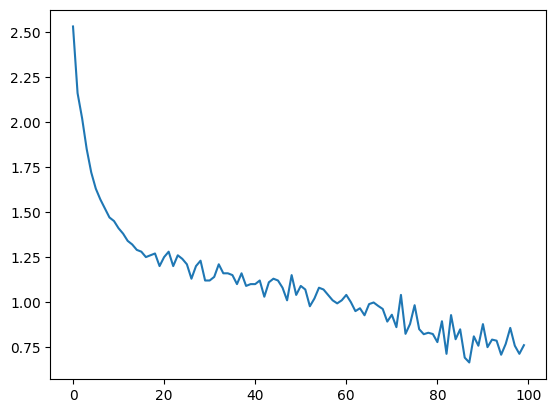

In [ ]:
plt.plot(losses)

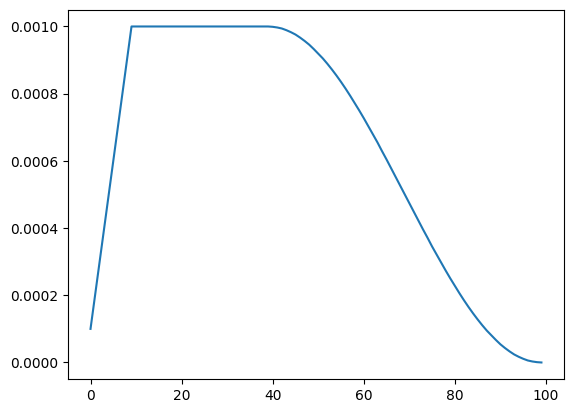

In [ ]:
plt.plot(learning_rates)

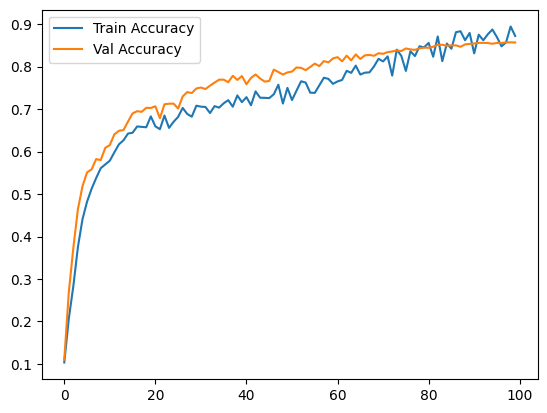

In [ ]:
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Val Accuracy")
plt.legend()
plt.show()

In [ ]:
import pandas as pd

data = {
    'Trial #': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    'Image size': [32, 32, 32, 32, 32, 32, 32, 64, 64, 64, 64],
    'Embedding dimension': [384, 384, 384, 192, 192, 192, 192, 252, 252, 252, 252],
    'Number of heads': [12, 12, 12, 12, 12, 8, 8, 12, 12, 12, 12],
    'Number of encoders': [8, 8, 8,  8, 8, 8, 6, 8, 8, 8, 12],
    'Batch size': [128, 128, 128, 128, 128, 128, 128, 128, 128, 512, 512],
    'Epochs': [20, 20, 50,  30, 30, 30, 30, 100, 100, 100, 100],
    'Patch size': [4, 4, 4,  4, 8, 4, 4, 4, 4, 4, 4],
    'Optimizer': ['SGD', 'Adam', 'SGD',  "AdamW", "AdamW", "AdamW", "AdamW", "AdamW", "AdamW", "AdamW", "AdamW"],
    'Learning rate': [0.001, 0.001, 0.1,  3e-4, 3e-4, 3e-4, "3e-4 with 1e-5 weight decay", "0.003 with 0.05 weight decay", "0.003 with 0.05 weight decay", "0.003 with 0.05 weight decay", "0.003 with 0.05 weight decay"],
    'Normalization': ['No', 'No', 'Yes',  'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes'],
    'Loss function': ['Cross entropy', 'Cross entropy', 'Cross entropy',  'Cross entropy', 'Cross entropy', 'Cross entropy', 'Cross entropy', 'Cross entropy + soft cross entropy', 'Cross entropy + soft cross entropy', 'Cross entropy + soft cross entropy', 'Cross entropy + soft cross entropy'],
    'Dropout regularization value': [None, 0.15, 0.15, 0.15, 0.15, 0.15, 0.10, 0.05, 0.05, 0.05, 0.05],
    'Data Augmentation': [None, None, "Jittering + horizontal flip", "Jittering + random crop + horizontal flip", "Jittering + random crop + horizontal flip",  "Jittering + random crop + horizontal flip", "Jittering + random crop + horizontal flip", "Jittering + random crop + horizontal flip + mild mixup starting at epoch 20", "Jittering + random crop + horizontal flip + mild mixup starting at epoch 20" , "Jittering + random crop + horizontal flip + mild mixup starting at epoch 10", "Jittering + random crop + horizontal flip + mild mixup starting at epoch 10 + mild cutmix starting at epoch 20"],
    'Scheduler': [None, None, None, "Cosine Annealing LR", "Cosine Annealing LR", "Cosine Annealing LR", "Cosine Annealing LR", "Cosine Annealing LR + linear warmup", "Cosine Annealing LR + linear warmup", "Cosine Annealing LR + linear warmup", "Custom scheduler implementation: Linear warmup + hold for 30 epochs + cosine decay"],
    'Accuracy %': [23.24, 23.24, 33.36, 10.00, 37.53,  70.49, 71.44, 75.69, 83.07, 84.21, 85.68],
}

# Create DataFrame
df = pd.DataFrame(data)
pd.set_option('display.max_colwidth', None)
df.transpose()

,0,1,2,3,4,5,6,7,8,9,10
Trial #,1,2,3,4,5,6,7,8,9,10,11
Image size,32,32,32,32,32,32,32,64,64,64,64
Embedding dimension,384,384,384,192,192,192,192,252,252,252,252
Number of heads,12,12,12,12,12,8,8,12,12,12,12
Number of encoders,8,8,8,8,8,8,6,8,8,8,12
Batch size,128,128,128,128,128,128,128,128,128,512,512
Epochs,20,20,50,30,30,30,30,100,100,100,100
Patch size,4,4,4,4,8,4,4,4,4,4,4
Optimizer,SGD,Adam,SGD,AdamW,AdamW,AdamW,AdamW,AdamW,AdamW,AdamW,AdamW
Learning rate,0.001,0.001,0.1,0.0003,0.0003,0.0003,3e-4 with 1e-5 weight decay,0.003 with 0.05 weight decay,0.003 with 0.05 weight decay,0.003 with 0.05 weight decay,0.003 with 0.05 weight decay


In [7]:
print("torch:", torch.__version__)
print("torchvision:", torchvision.__version__)

torch: 2.6.0+cu124
torchvision: 0.21.0+cu124
